# TARGT Classical HLA Exons

First let's load the necessary dependeicies.

In [1]:
import allel
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Next let's read in the original TGP and the updated VCF files for the classical HLA exons, both of which can be found in the `resources` directory.

In [2]:
# Load VCF files.
original_tgp_hla_vcf = './resources/tgp_hla_a_c_b_drb1_dqb1_exons_unfiltered.vcf.gz'
updated_tgp_hla_vcf = './resources/annotated_replaced_hla_exons.vcf.gz'
# Read each VCF file into memory.
original_tgp_callset = allel.read_vcf(
    original_tgp_hla_vcf,
    fields='*',
)
updated_tgp_callset = allel.read_vcf(
    updated_tgp_hla_vcf,
    fields='*',
)
# Extract the genotype arrays.
original_tgp_gt = allel.GenotypeArray(original_tgp_callset['calldata/GT'])
updated_tgp_gt = allel.GenotypeArray(updated_tgp_callset['calldata/GT'])

The original TGP dataset only contains variable positions while the updated TGP dataset contains genotype information for __ALL__ positions. Additionally both datasets contain other variants besides biallelic SNPs. For our purposes we will filter out any positions that are not biallelic SNPs in both datasets and also filter out sites with missing genotype information from the updated TGP dataset.

In [3]:
# Because the original TGP VCF file contains both INDELs and SNPs I will query SNPs using the VT flag in the VCF's INFO field.
snp_loc = original_tgp_callset['variants/VT' ][:] == 'SNP'
# Remove positions that are not SNPs.
original_tgp_gt_snps = original_tgp_gt.compress(snp_loc, axis=0)

All additional filtering will be done population by population so we need to load `integrated_call_samples_v3.20130502.ALL.panel` located in the `resources` directory and write a helper function to subset the datasets by specific populations.

In [4]:
# Define population subset function.
def tgp_subset(
    tgp_panel,
    tgp_gt,
    tgp_pop,
):
    """
    ###########################################################################
    INPUT
        tgp_panel: Meta information for the TGP (Pandas DataFrame)
        tgp_gt: Genotype matrix of all TGP samples (scikit-allel GenotypeArray)
        tgp_pop: Population of interest (str)
    ---------------------------------------------------------------------------
    OUTPUT: Genotype matrix corresponding to the population iof interest
    ###########################################################################
    """
    # Identify the samples belonging to said population.
    vals = tgp_panel['pop'].isin([tgp_pop]).values
    # Subset the TGP meta info to only include samples belonging to said
    # population.
    samps = tgp_panel[vals]
    # Grab the indicies of the samples belonging to said population.
    idx = samps.index.tolist()
    # Subset the genotype TGP genotype array to only include samples belonging
    # to said population.
    pop_gt = tgp_gt.take(idx, axis=1)
    return pop_gt
# Load TGP meta info file.
tgp_meta_info_path = './resources/integrated_call_samples_v3.20130502.ALL.panel'
tgp_meta_info = pd.read_csv(
    tgp_meta_info_path,
    sep='\t',
    usecols=['sample', 'pop', 'super_pop'],
)
# Subset the the TGP for admixed populations.
# First with the original TGP dataset.
original_clm_gt = tgp_subset(tgp_meta_info, original_tgp_gt_snps, 'CLM')
original_mxl_gt = tgp_subset(tgp_meta_info, original_tgp_gt_snps, 'MXL')
original_pel_gt = tgp_subset(tgp_meta_info, original_tgp_gt_snps, 'PEL')
original_pur_gt = tgp_subset(tgp_meta_info, original_tgp_gt_snps, 'PUR')
# And lastly with the updated TGP dataset.
updated_clm_gt = tgp_subset(tgp_meta_info, updated_tgp_gt, 'CLM')
updated_mxl_gt = tgp_subset(tgp_meta_info, updated_tgp_gt, 'MXL')
updated_pel_gt = tgp_subset(tgp_meta_info, updated_tgp_gt, 'PEL')
updated_pur_gt = tgp_subset(tgp_meta_info, updated_tgp_gt, 'PUR')

Next before filtering for only biallelic SNPs we must remove positions with missing data from each population indviually in the updated TGP dataset.

In [5]:
# Identify positions with missing genotype data for each population.
clm_missing_loc = updated_clm_gt.count_missing(axis=1) == 0
mxl_missing_loc = updated_mxl_gt.count_missing(axis=1) == 0
pel_missing_loc = updated_pel_gt.count_missing(axis=1) == 0
pur_missing_loc = updated_pur_gt.count_missing(axis=1) == 0
# Remove positions with missing genotype data for each population.
updated_clm_no_missing_gt = updated_clm_gt.compress(clm_missing_loc, axis=0)
updated_mxl_no_missing_gt = updated_mxl_gt.compress(mxl_missing_loc, axis=0)
updated_pel_no_missing_gt = updated_pel_gt.compress(pel_missing_loc, axis=0)
updated_pur_no_missing_gt = updated_pur_gt.compress(pur_missing_loc, axis=0)

Lastly, we will make sure that both datasets only contain biallelic SNPs—nothing more and nothing less.

In [6]:
# First we need to convert the filtered genotype arrays to allele count arrays.
# Orginal TGP dataset.
original_clm_ac = original_clm_gt.count_alleles()[:]
original_mxl_ac = original_mxl_gt.count_alleles()[:]
original_pel_ac = original_pel_gt.count_alleles()[:]
original_pur_ac = original_pur_gt.count_alleles()[:]
# Updated TGP dataset.
updated_clm_ac = updated_clm_no_missing_gt.count_alleles()[:]
updated_mxl_ac = updated_mxl_no_missing_gt.count_alleles()[:]
updated_pel_ac = updated_pel_no_missing_gt.count_alleles()[:]
updated_pur_ac = updated_pur_no_missing_gt.count_alleles()[:]
# Next we need to find the positions where we have biallelic SNPs.
# Orginal TGP dataset.
original_clm_biallelic_loc = original_clm_ac.is_biallelic() == True
original_mxl_biallelic_loc = original_mxl_ac.is_biallelic() == True
original_pel_biallelic_loc = original_pel_ac.is_biallelic() == True
original_pur_biallelic_loc = original_pur_ac.is_biallelic() == True
# Updated TGP dataset.
updated_clm_biallelic_loc = updated_clm_ac.is_biallelic() == True
updated_mxl_biallelic_loc = updated_mxl_ac.is_biallelic() == True
updated_pel_biallelic_loc = updated_pel_ac.is_biallelic() == True
updated_pur_biallelic_loc = updated_pur_ac.is_biallelic() == True
# Lastly we remove sites that are not biallelic.
# Orginal TGP dataset.
original_clm_filtered_ac = original_clm_ac.compress(original_clm_biallelic_loc, axis=0)[:, :2]
original_mxl_filtered_ac = original_mxl_ac.compress(original_mxl_biallelic_loc, axis=0)[:, :2]
original_pel_filtered_ac = original_pel_ac.compress(original_pel_biallelic_loc, axis=0)[:, :2]
original_pur_filtered_ac = original_pur_ac.compress(original_pur_biallelic_loc, axis=0)[:, :2]
# Updated TGP dataset.
updated_clm_filtered_ac = updated_clm_ac.compress(updated_clm_biallelic_loc, axis=0)[:, :2]
updated_mxl_filtered_ac = updated_mxl_ac.compress(updated_mxl_biallelic_loc, axis=0)[:, :2]
updated_pel_filtered_ac = updated_pel_ac.compress(updated_pel_biallelic_loc, axis=0)[:, :2]
updated_pur_filtered_ac = updated_pur_ac.compress(updated_pur_biallelic_loc, axis=0)[:, :2]

Now the fun part! First, we will compute and plot the the raw folded SFS.

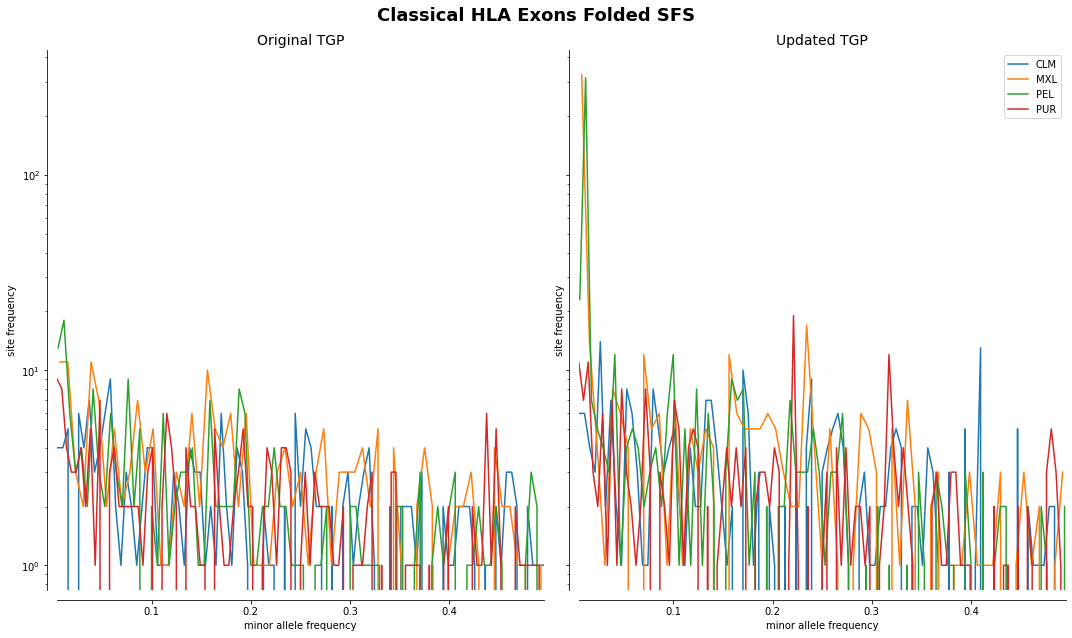

In [7]:
# First we compute the folded SFS from our filtered allele count arrays.
# Folded SFS: array where the kth element is the number of variant sites with a minor allele count of k.
# Orginal TGP dataset.
original_clm_sfs = allel.sfs_folded(original_clm_filtered_ac)
original_mxl_sfs = allel.sfs_folded(original_mxl_filtered_ac)
original_pel_sfs = allel.sfs_folded(original_pel_filtered_ac)
original_pur_sfs = allel.sfs_folded(original_pur_filtered_ac)
# Updated TGP dataset.
updated_clm_sfs = allel.sfs_folded(updated_clm_filtered_ac)
updated_mxl_sfs = allel.sfs_folded(updated_mxl_filtered_ac)
updated_pel_sfs = allel.sfs_folded(updated_pel_filtered_ac)
updated_pur_sfs = allel.sfs_folded(updated_pur_filtered_ac)
# Plot!
fig, axes = plt.subplots(1, 2, figsize=(15, 9), sharex=True, sharey=True)
sns.despine(ax=axes[0], offset=10)
sns.despine(ax=axes[1], offset=10)
allel.plot_sfs_folded(
    original_clm_sfs, ax=axes[0], label='CLM', 
    n=original_clm_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    original_mxl_sfs, ax=axes[0], label='MXL', 
    n=original_mxl_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    original_pel_sfs, ax=axes[0], label='PEL', 
    n=original_pel_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    original_pur_sfs, ax=axes[0], label='PUR', 
    n=original_pur_filtered_ac.sum(axis=1).max(),
)
axes[0].set_title('Original TGP', size=14)
allel.plot_sfs_folded(
    updated_clm_sfs, ax=axes[1], label='CLM', 
    n=updated_clm_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    updated_mxl_sfs, ax=axes[1], label='MXL', 
    n=updated_mxl_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    updated_pel_sfs, ax=axes[1], label='PEL', 
    n=updated_pel_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded(
    updated_pur_sfs, ax=axes[1], label='PUR', 
    n=updated_pur_filtered_ac.sum(axis=1).max(),
)
axes[1].set_title('Updated TGP', size=14)
axes[1].legend()
fig.suptitle('Classical HLA Exons Folded SFS', size=18, weight='bold')
fig.tight_layout()

Lastly we will compute and plot the the folded SFS scaled such that a constant value is expected across the spectrum for neutral variation and constant population size—i.e., populations with constant size should have a plotted SFS close to horizontal.

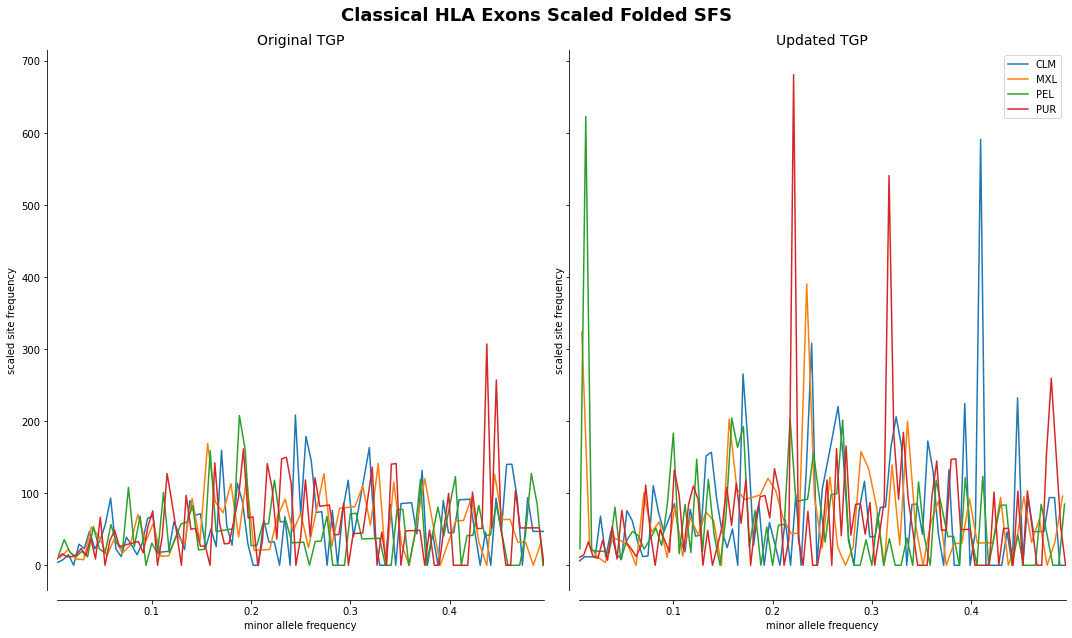

In [8]:
# First we compute the scaled folded SFS from our filtered allele count arrays.
# Scaled folded SFS: array where the value of the kth element is the number of variants with minor allele count k,
# multiplied by the scaling factor (k * (n - k) / n) where n is the total number of chromosomes called.
# Orginal TGP dataset.
original_clm_sfs_scaled = allel.sfs_folded_scaled(original_clm_filtered_ac)
original_mxl_sfs_scaled = allel.sfs_folded_scaled(original_mxl_filtered_ac)
original_pel_sfs_scaled = allel.sfs_folded_scaled(original_pel_filtered_ac)
original_pur_sfs_scaled = allel.sfs_folded_scaled(original_pur_filtered_ac)
# Updated TGP dataset.
updated_clm_sfs_scaled = allel.sfs_folded_scaled(updated_clm_filtered_ac)
updated_mxl_sfs_scaled = allel.sfs_folded_scaled(updated_mxl_filtered_ac)
updated_pel_sfs_scaled = allel.sfs_folded_scaled(updated_pel_filtered_ac)
updated_pur_sfs_scaled = allel.sfs_folded_scaled(updated_pur_filtered_ac)
# Plot!
fig, axes = plt.subplots(1, 2, figsize=(15, 9), sharex=True, sharey=True)
sns.despine(ax=axes[0], offset=10)
sns.despine(ax=axes[1], offset=10)
allel.plot_sfs_folded_scaled(
    original_clm_sfs_scaled, ax=axes[0], label='CLM', 
    n=original_clm_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    original_mxl_sfs_scaled, ax=axes[0], label='MXL', 
    n=original_mxl_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    original_pel_sfs_scaled, ax=axes[0], label='PEL', 
    n=original_pel_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    original_pur_sfs_scaled, ax=axes[0], label='PUR', 
    n=original_pur_filtered_ac.sum(axis=1).max(),
)
axes[0].set_title('Original TGP', size=14)
allel.plot_sfs_folded_scaled(
    updated_clm_sfs_scaled, ax=axes[1], label='CLM', 
    n=updated_clm_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    updated_mxl_sfs_scaled, ax=axes[1], label='MXL', 
    n=updated_mxl_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    updated_pel_sfs_scaled, ax=axes[1], label='PEL', 
    n=updated_pel_filtered_ac.sum(axis=1).max(),
)
allel.plot_sfs_folded_scaled(
    updated_pur_sfs_scaled, ax=axes[1], label='PUR', 
    n=updated_pur_filtered_ac.sum(axis=1).max(),
)
axes[1].set_title('Updated TGP', size=14)
axes[1].legend()
fig.suptitle('Classical HLA Exons Scaled Folded SFS', size=18, weight='bold')
fig.tight_layout()